# Notes

Used simplified version of the data used in the paper "Embeddings from protein language models predict conservation and variant effects" by Marquet et al.

**Data explanation**:
- `sequence.fasta`: FASTA file with the sequences of the proteines in the dataset
- `/labels/effect/*.effect`: Files with the SAVs of each protein. Encoded as, e.g., "X11Y 1" where X is the original AA, Y is the mutated AA, 11 is the position (1-indexed) and the last 1 means effect SAV and 0 means neutral SAV.
- `/labels/neutral/*.effect`: Same as `/labels/effect/*.effect`.

**Proposed splits**:
- `mixed`: train on wildtypes and training fols 0-8, test on test fold 9
- `human`: same as mixed but only with human proteins
- `only_savs`: same as mixed but without wildtypes

# Configs & Imports

In [1]:
from os import path
from pathlib import Path

from pandas import DataFrame, read_csv
from numpy import NaN, isnan, zeros

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import textdistance

import matplotlib.pyplot as plt
from IPython.display import display

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
# Where the raw data is stored and where processed data will be deposited
data_path = Path('') / '..' / 'data' / 'sav'

neutral_path = data_path / 'labels' / 'neutral'
neutral_files = neutral_path.rglob('*.effect')

effect_path = data_path / 'labels' / 'effect'
effect_files = effect_path.rglob('*.effect')

split_path = Path('') / '..' / 'splits' / 'sav'

folds = data_path / 'folds'

# Obtain original dataset

In [3]:
# Function to encapsulate the fasta data files
def getProteinsFromFASTAFile(filePath):
    columns = ["id", "sequence", "neutral", "effect"]
    dataset = DataFrame(columns = columns)
    
    for protein in tqdm(SeqIO.parse(filePath, "fasta")):
        dataset = dataset.append({"id": protein.id,
                                  "sequence": str(protein.seq)}, ignore_index=True)
    
    return dataset

In [4]:
# Create datadrame with all the sequences
data = getProteinsFromFASTAFile(data_path / "sequences.fasta")

9660it [09:40, 16.64it/s]


In [5]:
# Get the neutral SAVs
neutral_sav = dict()
for path in tqdm(neutral_files):
    name = str(path).split('/')[5]
    protein_name = name.split('.')[0]
    
    with open(path, 'r') as f:
        variations = f.read().splitlines()
        neutral_sav[protein_name] = list(map(lambda x: x.split(' ')[0], variations))

4233it [01:05, 64.24it/s] 


In [6]:
# Get the effect SAVs 
effect_sav = dict()
for path in tqdm(effect_files):
    name = str(path).split('/')[5]
    protein_name = name.split('.')[0]
    
    with open(path, 'r') as f:
        variations = f.read().splitlines()
        effect_sav[protein_name] = list(map(lambda x: x.split(' ')[0], variations))

7387it [01:21, 91.13it/s] 


In [7]:
# Add effect and neutral SAV to the dataframe
for i in tqdm(range(len(data))):
    id = data.iloc[i]["id"]
    
    if id in set(neutral_sav.keys()):
        data["neutral"].iloc[i] = neutral_sav[id]
    
    if id in set(effect_sav.keys()):
        data["effect"].iloc[i] = effect_sav[id]

100%|██████████████████████████████████████| 9660/9660 [00:44<00:00, 217.16it/s]


In [8]:
# Let's delete the proteins with < 40 residues
count_aa = [len(data.iloc[i].sequence) for i in range(len(data))]
indexes_less_40 = [i for i in range(len(count_aa)) if count_aa[i] < 40]
data = data.drop(index=indexes_less_40)
data = data.reset_index(drop=True)

In [9]:
# Check the dataset
data

,id,sequence,neutral,effect
0,A40493@yana,MEVSPLQPVNENMQVNKIKKNEDAKKRLSVERIYQKKTQLEHILLR...,NaN,"[R449Q, R486K]"
1,S17875@yana,MPFPVTTQGSQQTQPPQKHYGITSPISLAAPKETDCLLTQKLVETL...,[K96H],"[D125A, D125S, D128A, F100A, F100I, F98N, F98S..."
2,S37460@yana,MRRNSRARLGVSLLLVAGALGLGAAPSTAADTPPAAPSAIPAPSAY...,NaN,"[H315V, H340A, S328A, S328G]"
3,DCLBHP@yana,MSELDAKLNKLGVDRIAISPYKQWTRGYMEPGNIGNGYVTGLKVDA...,NaN,"[D199N, D54N, D64N, G59D, I60A, I60V, Y63F]"
4,AJECDS@yana,MGNNVVVLGTQWGDEGKGKIVDLLTERAKYVVRYQGGHNAGHTLVI...,NaN,"[D334E, D334N, D334Q, G13V, G16V, G18V, I20T, ..."
...,...,...,...,...
9641,A940612@direct1,RVTLSSKPQALATPNKEEHGKRKKKGKGLGKKRDPCLRKYKDFCIH...,"[K16A, K21A, K23A, K24A, K25A, K27A, K53A, R22...",NaN
9642,A984244@direct1,NTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAG...,"[A37E, D42A, E16A, E26A, E29A, E33A, E36A, E39...",NaN
9643,A000292@direct1,MAQTPAFDKPKVELHVHLDGSIKPETILYYGRRRGIALPANTAEGL...,"[A131D, D143A, E128D, G134N]",NaN
9644,A983849@direct1,MPEISLRHVVSGSSQDSTHCAENLLKADTYRKWRAATAGEKTISVV...,[Q221L],NaN


# Statistics

In [10]:
# Number of proteins with neutral and/or effect SAVs
count_neutral_proteins = len(data.loc[data["neutral"].notnull()])
count_effect_proteins = len(data.loc[data["effect"].notnull()])
count_only_neutral_proteins = len(data.loc[data["neutral"].notnull() & data["effect"].isnull()])
count_only_effect_proteins = len(data.loc[data["neutral"].isnull() & data["effect"].notnull()])
count_neutral_and_effect_proteins = len(data.loc[data["neutral"].notnull() & data["effect"].notnull()])


display("Number of proteins with neutral SAVs: " + str(count_neutral_proteins))
display("Number of proteins with effect SAVs: " + str(count_effect_proteins))
display("Number of proteins with only neutral SAVs: " + str(count_only_neutral_proteins))
display("Number of proteins with only effect SAVs: " + str(count_only_effect_proteins))
display("Number of proteins with neutral and effect SAVs: " + str(count_neutral_and_effect_proteins))

'Number of proteins with neutral SAVs: 4229'

'Number of proteins with effect SAVs: 7374'

'Number of proteins with only neutral SAVs: 2272'

'Number of proteins with only effect SAVs: 5417'

'Number of proteins with neutral and effect SAVs: 1957'

In [11]:
# Number of residues and number of residues with neutral or effect SAV
count_aa = [len(data.iloc[i].sequence) for i in range(len(data))]
neutral_savs = [data["neutral"].iloc[i] for i in range(len(data)) if i in data.loc[data["neutral"].notnull()].index]
effect_savs = [data["effect"].iloc[i] for i in range(len(data)) if i in data.loc[data["effect"].notnull()].index]

display("Total number of AAs: " + str(sum(count_aa)))
display("Size of the smallest protein: " + str(min(count_aa)))
display("Size of the largest protein: " + str(max(count_aa)))
display("Number of neutral SAVs: " + str(sum([len(protein_neutral_savs) for protein_neutral_savs in neutral_savs])))
display("Number of effect SAVs: " + str(sum([len(protein_effect_savs) for protein_effect_savs in effect_savs])))

'Total number of AAs: 4983475'

'Size of the smallest protein: 40'

'Size of the largest protein: 4967'

'Number of neutral SAVs: 39689'

'Number of effect SAVs: 60988'

In [12]:
# Let's count the different possible mutations
alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N',
           'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Y axis will be the original AA and the X acid the resulting AA
count_all_mutations = DataFrame(zeros((20,20), dtype=int), columns=alphabet)
count_all_mutations.index = alphabet

count_neutral_mutations = DataFrame(zeros((20,20), dtype=int), columns=alphabet)
count_neutral_mutations.index = alphabet

count_effect_mutations = DataFrame(zeros((20,20), dtype=int), columns=alphabet)
count_effect_mutations.index = alphabet

for i in range(len(data)):
    if i in data.loc[data["neutral"].notnull()].index:
        for j in range(len(data.iloc[i]["neutral"])):
            from_res = data.iloc[i]["neutral"][j][0]
            to_res = data.iloc[i]["neutral"][j][-1]
            count_all_mutations.loc[from_res][to_res] += 1
            count_neutral_mutations.loc[from_res][to_res] += 1
            
    if i in data.loc[data["effect"].notnull()].index:
        for j in range(len(data.iloc[i]["effect"])):
            from_res = data.iloc[i]["effect"][j][0]
            to_res = data.iloc[i]["effect"][j][-1]
            count_all_mutations.loc[from_res][to_res] += 1
            count_effect_mutations.loc[from_res][to_res] += 1

In [13]:
count_all_mutations

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A,0,152,340,376,77,544,59,78,121,146,45,86,493,90,129,878,1084,1059,36,50
C,785,0,49,15,206,294,46,23,13,54,21,15,18,17,446,1323,47,61,135,502
D,1393,80,0,1178,41,517,265,23,211,71,10,1760,57,97,115,232,86,258,10,262
E,1412,79,1142,0,45,421,89,42,1309,122,28,126,90,1194,147,161,82,234,22,45
F,563,233,38,45,0,60,57,171,32,713,29,28,33,27,41,388,29,203,143,503
G,1002,272,856,610,56,0,52,62,104,91,19,115,97,65,1075,832,73,587,100,25
H,879,97,235,104,145,135,0,24,155,257,22,535,166,594,486,154,44,49,20,445
I,434,93,30,38,205,52,21,0,99,605,317,191,45,31,81,179,537,1301,31,31
K,1287,70,103,879,67,172,122,143,0,164,233,426,52,668,1169,155,301,68,36,38
L,690,149,61,94,647,119,137,575,125,0,443,48,1147,233,490,305,107,666,104,82


In [14]:
count_neutral_mutations

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A,0,104,112,208,24,374,29,50,77,76,25,60,165,69,82,706,479,422,9,24
C,304,0,11,2,25,56,12,10,3,22,7,3,4,7,39,389,17,22,6,30
D,439,24,0,670,6,126,55,7,78,12,4,513,27,43,36,98,54,29,0,24
E,633,35,695,0,19,132,37,26,325,56,12,77,52,536,73,94,62,95,3,20
F,144,85,6,13,0,14,23,60,9,279,16,4,7,13,8,62,10,63,60,345
G,416,63,129,98,12,0,22,6,45,16,3,72,15,39,88,233,29,59,10,8
H,238,29,53,33,51,34,0,12,44,59,9,182,27,200,163,54,18,18,8,143
I,152,64,4,12,65,9,10,0,32,513,199,33,15,22,19,58,155,1106,5,9
K,507,29,45,319,19,65,48,48,0,61,70,202,18,373,739,77,152,36,9,17
L,240,95,15,34,291,18,47,479,47,0,365,13,87,83,86,87,65,421,24,37


In [15]:
count_effect_mutations

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A,0,48,228,168,53,170,30,28,44,70,20,26,328,21,47,172,605,637,27,26
C,481,0,38,13,181,238,34,13,10,32,14,12,14,10,407,934,30,39,129,472
D,954,56,0,508,35,391,210,16,133,59,6,1247,30,54,79,134,32,229,10,238
E,779,44,447,0,26,289,52,16,984,66,16,49,38,658,74,67,20,139,19,25
F,419,148,32,32,0,46,34,111,23,434,13,24,26,14,33,326,19,140,83,158
G,586,209,727,512,44,0,30,56,59,75,16,43,82,26,987,599,44,528,90,17
H,641,68,182,71,94,101,0,12,111,198,13,353,139,394,323,100,26,31,12,302
I,282,29,26,26,140,43,11,0,67,92,118,158,30,9,62,121,382,195,26,22
K,780,41,58,560,48,107,74,95,0,103,163,224,34,295,430,78,149,32,27,21
L,450,54,46,60,356,101,90,96,78,0,78,35,1060,150,404,218,42,245,80,45


In [16]:
# Let's count the number of proteins with 1, 2, 3, ... mutations
counts_of_protein_mutations = dict()
indexes_for_number_mutations = dict()

for i in range(len(data)):
    current_count = 0
    
    if i in data.loc[data["neutral"].notnull()].index:
        current_count += len(data.iloc[i]["neutral"])
        
    if i in data.loc[data["effect"].notnull()].index:
        current_count += len(data.iloc[i]["effect"])
    
    if current_count in counts_of_protein_mutations.keys():
        counts_of_protein_mutations[current_count] += 1
        indexes_for_number_mutations[current_count].append(i)
    else:
        counts_of_protein_mutations[current_count] = 1
        indexes_for_number_mutations[current_count] = [i]

In [17]:
for count in sorted(counts_of_protein_mutations):
    # Proteins with X mutation: Number of proteins
    print("%s: %s" % (count, counts_of_protein_mutations[count]))

1: 1827
2: 1245
3: 953
4: 724
5: 506
6: 448
7: 371
8: 363
9: 294
10: 262
11: 225
12: 186
13: 182
14: 170
15: 133
16: 137
17: 107
18: 112
19: 102
20: 95
21: 80
22: 70
23: 60
24: 74
25: 66
26: 60
27: 44
28: 49
29: 42
30: 41
31: 49
32: 45
33: 28
34: 30
35: 26
36: 23
37: 35
38: 22
39: 16
40: 17
41: 25
42: 12
43: 7
44: 8
45: 6
46: 8
47: 12
48: 7
49: 9
50: 8
51: 6
52: 7
53: 5
54: 8
55: 4
56: 2
57: 2
58: 5
59: 3
60: 5
61: 6
62: 4
63: 5
64: 4
65: 1
66: 6
67: 7
68: 5
69: 5
70: 3
71: 3
72: 3
73: 2
74: 2
75: 4
76: 3
77: 2
78: 1
79: 1
80: 2
81: 5
82: 1
83: 3
84: 2
85: 4
86: 2
87: 1
88: 4
89: 2
91: 1
93: 4
94: 1
96: 1
97: 2
98: 3
99: 3
101: 2
102: 2
103: 2
104: 1
105: 1
107: 2
108: 1
110: 1
111: 1
112: 3
113: 1
114: 1
115: 1
116: 2
120: 3
121: 1
122: 2
124: 1
129: 1
131: 2
132: 2
133: 2
142: 1
143: 2
144: 1
145: 1
146: 2
149: 1
152: 1
153: 1
154: 1
156: 1
167: 1
169: 1
172: 1
173: 2
174: 1
184: 2
186: 1
196: 1
201: 1
235: 1
242: 1
254: 1
294: 1
336: 1
355: 1
364: 2
397: 1
444: 1
576: 1
1636: 1


<BarContainer object of 50 artists>

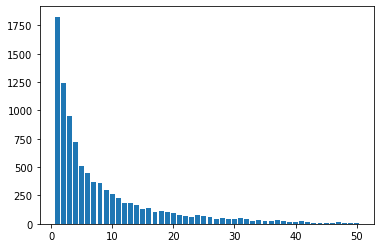

In [18]:
# We have insignificant number of proteins with > 45 mutations. We delete them to visualize the histogram
for i in [k for k in counts_of_protein_mutations.keys() if k > 50]:
    del counts_of_protein_mutations[i]

# Plot histogram
plt.bar(counts_of_protein_mutations.keys(), counts_of_protein_mutations.values())

In [19]:
# Let's count the number of residues with more than one variation
residues_with_more_than_one_variation = {}

for i in range(len(data)):
    if i in data.loc[data["neutral"].notnull()].index:
        for j in range(len(data.iloc[i]["neutral"])):
            position = int(data.iloc[i]["neutral"][j][1:-1])
            if (i, position) in residues_with_more_than_one_variation:
                residues_with_more_than_one_variation[(i, position)] += 1
            else:
                residues_with_more_than_one_variation[(i, position)] = 1
    
    if i in data.loc[data["effect"].notnull()].index:
        for j in range(len(data.iloc[i]["effect"])):
            position = int(data.iloc[i]["effect"][j][1:-1])
            if (i, position) in residues_with_more_than_one_variation:
                residues_with_more_than_one_variation[(i, position)] += 1
            else:
                residues_with_more_than_one_variation[(i, position)] = 1

In [20]:
# Let's visualize for each proteins those residues with more than one variation
for (protein_id, residue) in residues_with_more_than_one_variation:
    if residues_with_more_than_one_variation[(protein_id, residue)] > 1:
        print(str((protein_id, residue)) + ": " + str(residues_with_more_than_one_variation[(protein_id, residue)]))

(1, 96): 2
(1, 125): 2
(1, 100): 2
(1, 98): 2
(2, 328): 2
(3, 60): 2
(4, 334): 3
(4, 332): 2
(8, 61): 2
(9, 39): 4
(9, 15): 2
(9, 157): 2
(9, 153): 5
(12, 157): 2
(16, 478): 8
(16, 114): 3
(16, 363): 2
(16, 367): 2
(17, 64): 2
(18, 345): 2
(18, 347): 2
(18, 346): 2
(18, 350): 3
(18, 348): 4
(18, 344): 3
(18, 349): 3
(19, 537): 3
(20, 168): 2
(20, 169): 2
(20, 170): 4
(21, 120): 2
(26, 79): 3
(28, 38): 2
(29, 106): 3
(29, 299): 2
(29, 101): 2
(29, 51): 3
(29, 135): 2
(29, 85): 2
(29, 138): 2
(29, 232): 2
(29, 289): 2
(29, 53): 3
(30, 35): 3
(30, 47): 2
(30, 50): 2
(34, 88): 4
(34, 95): 2
(34, 36): 2
(34, 45): 3
(34, 48): 2
(34, 53): 2
(34, 54): 4
(34, 41): 2
(34, 86): 2
(34, 91): 3
(34, 43): 4
(35, 110): 2
(35, 163): 2
(36, 246): 2
(36, 140): 3
(37, 329): 2
(37, 81): 2
(39, 213): 2
(39, 212): 2
(40, 88): 2
(40, 145): 3
(40, 87): 2
(40, 72): 2
(40, 79): 2
(41, 638): 2
(47, 322): 2
(48, 107): 14
(50, 172): 2
(50, 95): 3
(50, 12): 3
(50, 78): 3
(53, 154): 8
(53, 162): 2
(53, 157): 7
(53, 1

(480, 332): 7
(481, 94): 2
(483, 361): 2
(484, 196): 2
(484, 344): 2
(486, 10): 3
(487, 161): 2
(487, 177): 2
(487, 199): 2
(487, 249): 5
(487, 263): 7
(487, 162): 2
(487, 206): 3
(487, 158): 2
(487, 228): 3
(487, 239): 3
(487, 135): 2
(487, 210): 2
(487, 175): 3
(487, 212): 4
(487, 152): 16
(487, 137): 2
(487, 148): 2
(487, 241): 3
(487, 142): 13
(487, 146): 14
(487, 181): 3
(487, 138): 9
(487, 264): 3
(487, 229): 3
(487, 136): 4
(487, 127): 2
(487, 141): 4
(487, 220): 6
(487, 248): 2
(487, 128): 2
(488, 227): 3
(488, 345): 3
(488, 597): 3
(489, 49): 3
(494, 250): 2
(495, 288): 2
(495, 290): 2
(495, 292): 2
(496, 113): 2
(496, 116): 2
(496, 190): 11
(496, 74): 6
(496, 151): 2
(496, 215): 9
(496, 115): 2
(496, 181): 3
(496, 271): 3
(496, 443): 3
(496, 498): 2
(496, 478): 2
(496, 263): 3
(496, 494): 3
(496, 156): 3
(498, 657): 2
(498, 708): 2
(498, 742): 2
(498, 558): 2
(500, 42): 2
(502, 248): 2
(502, 249): 2
(503, 31): 2
(504, 527): 2
(505, 351): 3
(505, 186): 4
(505, 88): 2
(505, 113

(3172, 483): 2
(3172, 354): 2
(3176, 257): 2
(3176, 116): 2
(3185, 114): 2
(3185, 152): 2
(3185, 280): 2
(3186, 286): 2
(3186, 328): 2
(3186, 330): 2
(3187, 270): 3
(3187, 185): 3
(3187, 75): 2
(3187, 181): 3
(3187, 226): 2
(3187, 229): 3
(3187, 248): 2
(3187, 338): 2
(3187, 375): 2
(3194, 107): 2
(3196, 120): 2
(3196, 288): 2
(3196, 102): 2
(3203, 358): 2
(3204, 868): 2
(3204, 870): 2
(3205, 246): 2
(3208, 156): 4
(3208, 160): 3
(3212, 241): 2
(3212, 250): 2
(3212, 260): 3
(3212, 270): 2
(3212, 272): 2
(3212, 253): 2
(3214, 18): 2
(3214, 84): 2
(3215, 601): 2
(3218, 293): 2
(3218, 308): 2
(3219, 379): 2
(3222, 69): 3
(3222, 184): 2
(3222, 402): 3
(3222, 346): 2
(3224, 406): 2
(3228, 60): 2
(3245, 347): 2
(3254, 249): 2
(3263, 3008): 2
(3269, 545): 2
(3274, 15): 2
(3277, 2102): 2
(3278, 148): 2
(3278, 149): 2
(3280, 636): 2
(3284, 3): 2
(3284, 8): 2
(3284, 22): 2
(3284, 25): 2
(3284, 28): 2
(3284, 34): 4
(3284, 39): 2
(3284, 40): 2
(3284, 49): 2
(3284, 64): 2
(3284, 75): 3
(3284, 86): 

(4168, 106): 3
(4170, 729): 2
(4171, 242): 3
(4172, 184): 2
(4172, 106): 2
(4172, 190): 2
(4172, 191): 2
(4172, 113): 2
(4172, 262): 2
(4173, 370): 2
(4173, 369): 2
(4173, 434): 3
(4173, 331): 2
(4173, 368): 2
(4173, 371): 2
(4173, 373): 3
(4173, 120): 13
(4173, 229): 6
(4173, 400): 2
(4174, 155): 3
(4174, 44): 2
(4174, 49): 2
(4174, 88): 2
(4174, 145): 7
(4174, 27): 5
(4174, 31): 2
(4174, 121): 9
(4174, 67): 7
(4174, 61): 2
(4174, 91): 2
(4174, 94): 2
(4174, 112): 2
(4174, 28): 3
(4174, 54): 4
(4174, 42): 2
(4174, 148): 3
(4174, 46): 2
(4174, 133): 2
(4174, 22): 3
(4174, 74): 2
(4174, 100): 2
(4175, 245): 3
(4176, 177): 2
(4176, 179): 2
(4178, 228): 2
(4178, 225): 3
(4178, 197): 3
(4178, 215): 3
(4178, 248): 2
(4178, 56): 2
(4180, 677): 2
(4180, 676): 2
(4181, 175): 3
(4181, 14): 4
(4181, 10): 5
(4181, 180): 4
(4181, 151): 2
(4181, 177): 6
(4181, 41): 3
(4181, 157): 5
(4185, 699): 19
(4187, 395): 2
(4189, 227): 2
(4189, 318): 2
(4189, 251): 2
(4189, 230): 2
(4191, 24): 2
(4191, 133): 

(4413, 339): 5
(4413, 62): 3
(4413, 328): 5
(4414, 32): 2
(4415, 344): 5
(4415, 442): 4
(4417, 118): 4
(4417, 54): 3
(4417, 154): 5
(4419, 871): 7
(4423, 118): 5
(4425, 101): 2
(4425, 271): 11
(4426, 447): 5
(4427, 458): 2
(4427, 456): 2
(4428, 31): 2
(4428, 65): 2
(4429, 307): 2
(4429, 364): 2
(4429, 190): 3
(4429, 201): 4
(4429, 341): 5
(4430, 38): 6
(4430, 99): 2
(4430, 101): 2
(4432, 365): 2
(4432, 338): 3
(4432, 206): 2
(4432, 340): 2
(4434, 287): 2
(4435, 384): 3
(4435, 4): 4
(4435, 195): 3
(4435, 554): 2
(4437, 170): 2
(4437, 473): 2
(4437, 479): 2
(4437, 488): 3
(4438, 186): 2
(4439, 388): 2
(4439, 381): 3
(4439, 267): 2
(4439, 206): 3
(4440, 82): 2
(4443, 243): 4
(4443, 1): 3
(4444, 274): 2
(4446, 55): 4
(4448, 37): 2
(4448, 150): 2
(4448, 59): 2
(4449, 181): 2
(4449, 68): 2
(4449, 321): 3
(4449, 93): 3
(4455, 298): 2
(4455, 295): 2
(4456, 256): 4
(4456, 101): 2
(4456, 120): 2
(4456, 182): 2
(4456, 194): 2
(4456, 213): 2
(4456, 89): 2
(4456, 94): 2
(4457, 75): 2
(4457, 286): 3

(4744, 121): 3
(4744, 232): 3
(4745, 235): 2
(4745, 66): 9
(4745, 233): 3
(4745, 211): 4
(4745, 240): 2
(4746, 91): 3
(4746, 90): 4
(4746, 92): 7
(4747, 857): 3
(4747, 162): 3
(4747, 861): 3
(4748, 1651): 3
(4748, 1657): 6
(4748, 1656): 7
(4749, 290): 2
(4750, 473): 6
(4750, 475): 5
(4750, 439): 4
(4750, 373): 3
(4750, 378): 2
(4750, 442): 17
(4750, 374): 2
(4750, 444): 3
(4750, 375): 3
(4751, 90): 3
(4753, 14): 7
(4753, 15): 3
(4754, 165): 2
(4754, 127): 6
(4754, 126): 3
(4754, 307): 3
(4754, 315): 3
(4754, 213): 3
(4755, 159): 2
(4755, 133): 2
(4755, 138): 3
(4755, 153): 2
(4755, 155): 3
(4755, 135): 2
(4755, 156): 5
(4756, 105): 2
(4756, 102): 3
(4756, 108): 3
(4756, 110): 3
(4756, 103): 3
(4756, 104): 2
(4756, 116): 2
(4756, 117): 10
(4756, 124): 2
(4756, 101): 2
(4756, 113): 2
(4761, 207): 2
(4762, 1015): 2
(4763, 567): 3
(4763, 576): 2
(4765, 158): 3
(4765, 174): 2
(4766, 33): 2
(4766, 74): 3
(4766, 1): 2
(4766, 30): 2
(4767, 119): 4
(4767, 201): 4
(4767, 146): 6
(4768, 756): 2
(

(5129, 162): 3
(5129, 204): 4
(5129, 209): 10
(5129, 213): 6
(5129, 205): 5
(5129, 203): 2
(5129, 207): 4
(5129, 131): 2
(5129, 127): 8
(5129, 121): 3
(5129, 206): 6
(5129, 124): 2
(5129, 187): 2
(5129, 167): 2
(5129, 221): 3
(5129, 146): 7
(5129, 172): 2
(5129, 208): 5
(5129, 210): 5
(5129, 219): 2
(5129, 126): 5
(5129, 123): 2
(5129, 120): 10
(5129, 214): 2
(5129, 125): 6
(5131, 114): 3
(5131, 31): 2
(5131, 156): 2
(5131, 326): 2
(5131, 113): 2
(5131, 105): 3
(5132, 617): 2
(5133, 349): 4
(5133, 350): 4
(5134, 209): 2
(5134, 223): 5
(5135, 759): 2
(5136, 434): 3
(5136, 167): 2
(5136, 426): 18
(5139, 177): 2
(5139, 183): 2
(5139, 205): 3
(5139, 237): 2
(5139, 124): 2
(5139, 234): 3
(5139, 206): 3
(5139, 224): 2
(5139, 257): 2
(5140, 68): 2
(5140, 188): 2
(5140, 184): 3
(5140, 79): 2
(5140, 72): 2
(5140, 75): 3
(5140, 74): 2
(5140, 76): 2
(5140, 70): 3
(5141, 275): 3
(5141, 227): 3
(5141, 139): 3
(5141, 230): 2
(5141, 226): 2
(5142, 256): 2
(5142, 176): 2
(5143, 95): 4
(5143, 280): 2
(

(5476, 132): 4
(5477, 213): 2
(5477, 303): 2
(5477, 210): 4
(5477, 304): 2
(5477, 118): 4
(5478, 289): 3
(5480, 10): 2
(5480, 199): 2
(5480, 206): 2
(5480, 175): 2
(5481, 109): 2
(5484, 89): 2
(5485, 53): 11
(5486, 92): 2
(5489, 229): 4
(5489, 37): 3
(5491, 260): 3
(5491, 261): 2
(5493, 8): 3
(5493, 6): 2
(5493, 499): 3
(5493, 495): 2
(5493, 7): 2
(5493, 4): 2
(5493, 494): 3
(5493, 10): 2
(5493, 2): 2
(5493, 5): 3
(5494, 48): 3
(5494, 14): 3
(5494, 49): 3
(5494, 12): 3
(5496, 310): 3
(5498, 134): 2
(5498, 55): 2
(5498, 141): 9
(5498, 68): 2
(5498, 64): 2
(5499, 264): 6
(5499, 275): 7
(5499, 276): 3
(5499, 278): 2
(5499, 270): 3
(5501, 286): 2
(5501, 331): 2
(5501, 61): 2
(5502, 44): 2
(5506, 99): 2
(5507, 537): 2
(5509, 327): 2
(5509, 79): 4
(5509, 82): 2
(5509, 81): 2
(5509, 113): 3
(5509, 130): 2
(5509, 268): 3
(5509, 312): 6
(5511, 213): 2
(5511, 75): 15
(5511, 359): 12
(5511, 196): 2
(5511, 141): 5
(5511, 192): 2
(5511, 382): 6
(5511, 409): 2
(5512, 316): 2
(5514, 188): 4
(5515, 88

(6002, 61): 2
(6004, 283): 2
(6005, 247): 11
(6005, 606): 8
(6005, 613): 5
(6005, 614): 5
(6005, 245): 10
(6005, 607): 9
(6005, 609): 8
(6005, 246): 7
(6005, 248): 4
(6005, 611): 10
(6005, 612): 6
(6005, 608): 8
(6005, 610): 13
(6005, 244): 8
(6006, 157): 2
(6006, 198): 2
(6007, 34): 2
(6007, 54): 2
(6007, 14): 2
(6008, 278): 2
(6008, 56): 3
(6008, 87): 2
(6008, 399): 3
(6008, 196): 2
(6008, 104): 2
(6008, 235): 2
(6008, 131): 2
(6008, 189): 3
(6009, 248): 2
(6011, 605): 2
(6013, 431): 2
(6013, 465): 2
(6013, 487): 2
(6013, 430): 3
(6014, 111): 2
(6014, 155): 2
(6015, 30): 2
(6015, 31): 2
(6016, 340): 2
(6017, 256): 2
(6017, 42): 2
(6017, 89): 5
(6017, 191): 4
(6020, 377): 4
(6020, 381): 2
(6021, 72): 2
(6022, 33): 4
(6022, 232): 2
(6022, 181): 2
(6023, 118): 2
(6023, 30): 3
(6027, 443): 2
(6027, 451): 2
(6027, 445): 2
(6027, 446): 3
(6027, 447): 2
(6027, 440): 2
(6027, 449): 2
(6031, 314): 2
(6032, 144): 3
(6032, 236): 2
(6032, 146): 2
(6032, 177): 3
(6032, 195): 3
(6032, 275): 3
(603

(6417, 140): 9
(6417, 138): 2
(6417, 37): 2
(6417, 64): 3
(6417, 141): 2
(6417, 142): 3
(6417, 104): 2
(6417, 68): 3
(6418, 65): 2
(6418, 421): 2
(6418, 522): 2
(6421, 452): 2
(6421, 431): 4
(6421, 427): 2
(6422, 367): 4
(6422, 151): 2
(6423, 35): 3
(6423, 180): 5
(6423, 211): 3
(6423, 133): 2
(6423, 246): 6
(6423, 280): 4
(6423, 374): 6
(6423, 130): 2
(6423, 214): 2
(6423, 65): 3
(6424, 147): 2
(6425, 199): 2
(6425, 189): 2
(6425, 172): 2
(6425, 191): 2
(6425, 190): 3
(6425, 77): 2
(6426, 88): 4
(6427, 206): 2
(6427, 296): 2
(6431, 192): 2
(6431, 184): 3
(6431, 189): 5
(6433, 33): 2
(6433, 56): 8
(6433, 51): 4
(6433, 27): 3
(6433, 36): 3
(6433, 47): 5
(6433, 20): 2
(6433, 19): 2
(6433, 1): 6
(6433, 2): 7
(6433, 63): 5
(6433, 5): 2
(6433, 60): 3
(6433, 4): 3
(6433, 3): 4
(6435, 238): 7
(6435, 239): 17
(6435, 253): 3
(6435, 260): 4
(6435, 267): 3
(6435, 274): 7
(6435, 235): 15
(6436, 44): 2
(6437, 208): 7
(6437, 200): 2
(6437, 198): 2
(6437, 201): 2
(6437, 63): 4
(6437, 206): 7
(6437, 2

(6782, 269): 2
(6782, 281): 2
(6784, 58): 2
(6789, 273): 2
(6790, 535): 2
(6791, 59): 6
(6794, 101): 9
(6796, 104): 2
(6802, 71): 3
(6804, 26): 2
(6805, 126): 2
(6807, 313): 2
(6807, 391): 2
(6807, 315): 2
(6808, 148): 2
(6812, 180): 2
(6812, 182): 2
(6813, 423): 3
(6814, 40): 2
(6814, 42): 2
(6815, 429): 2
(6815, 443): 2
(6818, 2): 3
(6821, 54): 2
(6822, 4): 2
(6826, 141): 2
(6826, 142): 2
(6826, 134): 2
(6828, 342): 2
(6829, 179): 3
(6829, 185): 2
(6831, 420): 2
(6832, 187): 3
(6834, 23): 2
(6839, 249): 2
(6839, 250): 3
(6842, 360): 5
(6842, 354): 5
(6842, 351): 5
(6851, 109): 4
(6852, 104): 8
(6852, 102): 8
(6853, 86): 2
(6854, 227): 2
(6858, 243): 2
(6861, 165): 2
(6866, 83): 2
(6867, 290): 3
(6870, 151): 2
(6871, 181): 2
(6871, 115): 2
(6871, 221): 2
(6871, 46): 2
(6872, 211): 3
(6874, 143): 2
(6874, 52): 2
(6874, 60): 2
(6874, 15): 3
(6874, 242): 2
(6875, 141): 2
(6875, 23): 2
(6876, 143): 2
(6879, 8): 2
(6879, 2): 2
(6879, 24): 2
(6879, 35): 2
(6880, 307): 4
(6880, 298): 3
(6880

In [21]:
# Count human proteins
human_ids = []

for i in range(len(data)):
    if "HUMAN" in data.iloc[i]["id"]:
        human_ids.append(data.iloc[i]["id"])

print("Human proteins: " + str(len(human_ids)))

Human proteins: 959


# Expanded datasets

In [22]:
wildtypes = DataFrame(columns = ["id", "sequence", "variation"])
savs = DataFrame(columns = ["id", "sequence", "variation_index", "variation"])

In [23]:
# Let's create the (expanded) dataframe of wild types
for i in tqdm(range(len(data))):
    wildtypes = wildtypes.append({
        "id": data.iloc[i]["id"],
        "sequence": data.iloc[i]["sequence"],
        "variation": "wt"
    }, ignore_index = True)

100%|██████████████████████████████████████| 9646/9646 [01:07<00:00, 142.93it/s]


In [24]:
# Let's create the (expanded) dataframe of SAVS
# First save in dictionary because it is more efficient than DataFrame.append()
dict_index = 0
savs_dict = dict()
for i in tqdm(range(len(data))):
    if i in data.loc[data["neutral"].notnull()].index:
        for j in range(len(data.iloc[i]["neutral"])):
            mutant_seq = list(data.iloc[i]["sequence"])
            mutation_index = int(data.iloc[i]["neutral"][j][1:-1])

            mutant_seq[mutation_index - 1] = data.iloc[i]["neutral"][j][-1]

            savs_dict[dict_index] = {
                "id": data.iloc[i]["id"],
                "sequence": "".join(mutant_seq),
                "variation_index": mutation_index,
                "variation": "neutral"
            }

            dict_index += 1

    if i in data.loc[data["effect"].notnull()].index:
        for j in range(len(data.iloc[i]["effect"])):
            mutant_seq = list(data.iloc[i]["sequence"])
            mutation_index = int(data.iloc[i]["effect"][j][1:-1])

            mutant_seq[mutation_index - 1] = data.iloc[i]["effect"][j][-1]

            savs_dict[dict_index] = {
                "id": data.iloc[i]["id"],
                "sequence": "".join(mutant_seq),
                "variation_index": mutation_index,
                "variation": "effect"
            }

            dict_index += 1

savs = DataFrame.from_dict(savs_dict, "index")

100%|███████████████████████████████████████| 9646/9646 [03:32<00:00, 45.29it/s]


In [25]:
# Let's look at the data
wildtypes

,id,sequence,variation
0,A40493@yana,MEVSPLQPVNENMQVNKIKKNEDAKKRLSVERIYQKKTQLEHILLR...,wt
1,S17875@yana,MPFPVTTQGSQQTQPPQKHYGITSPISLAAPKETDCLLTQKLVETL...,wt
2,S37460@yana,MRRNSRARLGVSLLLVAGALGLGAAPSTAADTPPAAPSAIPAPSAY...,wt
3,DCLBHP@yana,MSELDAKLNKLGVDRIAISPYKQWTRGYMEPGNIGNGYVTGLKVDA...,wt
4,AJECDS@yana,MGNNVVVLGTQWGDEGKGKIVDLLTERAKYVVRYQGGHNAGHTLVI...,wt
...,...,...,...
9641,A940612@direct1,RVTLSSKPQALATPNKEEHGKRKKKGKGLGKKRDPCLRKYKDFCIH...,wt
9642,A984244@direct1,NTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAG...,wt
9643,A000292@direct1,MAQTPAFDKPKVELHVHLDGSIKPETILYYGRRRGIALPANTAEGL...,wt
9644,A983849@direct1,MPEISLRHVVSGSSQDSTHCAENLLKADTYRKWRAATAGEKTISVV...,wt


In [26]:
savs

,id,sequence,variation_index,variation
0,A40493@yana,MEVSPLQPVNENMQVNKIKKNEDAKKRLSVERIYQKKTQLEHILLR...,449,effect
1,A40493@yana,MEVSPLQPVNENMQVNKIKKNEDAKKRLSVERIYQKKTQLEHILLR...,486,effect
2,S17875@yana,MPFPVTTQGSQQTQPPQKHYGITSPISLAAPKETDCLLTQKLVETL...,96,neutral
3,S17875@yana,MPFPVTTQGSQQTQPPQKHYGITSPISLAAPKETDCLLTQKLVETL...,125,effect
4,S17875@yana,MPFPVTTQGSQQTQPPQKHYGITSPISLAAPKETDCLLTQKLVETL...,125,effect
...,...,...,...,...
100672,A000292@direct1,MAQTPAFDKPKVELHVHLDGSIKPETILYYGRRRGIALPANTAEGL...,143,neutral
100673,A000292@direct1,MAQTPAFDKPKVELHVHLDGSIKPETILYYGRRRGIALPANTAEGL...,128,neutral
100674,A000292@direct1,MAQTPAFDKPKVELHVHLDGSIKPETILYYGRRRGIALPANTAEGL...,134,neutral
100675,A983849@direct1,MPEISLRHVVSGSSQDSTHCAENLLKADTYRKWRAATAGEKTISVV...,221,neutral


In [27]:
# Get human sequences from SAVs
human_savs_indexes = []
for i in range(len(savs)):
    if "HUMAN" in savs.iloc[i]["id"]:
        human_savs_indexes.append(i)

# Splits

In [28]:
# Get the folds
training_ids = []
for i in range(9):
    with open(folds / ("fold_" + str(i) + ".txt")) as fold_file:
        lines = fold_file.readlines()
        ids = [line.rstrip() for line in lines]
        training_ids = training_ids + ids
        
test_ids = []
with open(folds / "fold_9.txt") as fold_file:
    lines = fold_file.readlines()
    test_ids = [line.rstrip() for line in lines]
       
# Delete part after '.'
training_ids = list(map(lambda s: s.split('.')[0], training_ids))
test_ids = list(map(lambda s: s.split('.')[0], test_ids))

In [29]:
# Get wildtypes of training folds
train_wildtypes = wildtypes.loc[wildtypes['id'].apply(lambda s: s.split('@')[0]).isin(training_ids)]

# Get wildtypes of test fold
test_wildtypes = wildtypes.loc[wildtypes['id'].apply(lambda s: s.split('@')[0]).isin(test_ids)]

# Get SAVs of training fols
train_savs = savs.loc[savs['id'].apply(lambda s: s.split('@')[0]).isin(training_ids)]

# Get SAVs of test fold
test_savs = savs.loc[savs['id'].apply(lambda s: s.split('@')[0]).isin(test_ids)]

In [30]:
# Get human wildtypes of training folds
train_human_wildtypes = train_wildtypes[train_wildtypes['id'].str.contains("HUMAN")]

# Get human widltypes of test fold
test_human_wildtypes = test_wildtypes[test_wildtypes['id'].str.contains("HUMAN")]

# Get human SAVs of training fols
train_human_savs = train_savs[train_savs['id'].str.contains("HUMAN")]

# Get human SAVs of test fold
test_human_savs = test_savs[test_savs['id'].str.contains("HUMAN")]

## mixed

In [31]:
# Let's create the split dataset
mixed = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Add train samples (wild types + folds 1-8)
tmp = train_wildtypes
tmp = tmp.append(test_wildtypes[["sequence", "variation"]])
tmp = tmp.append(train_savs[["sequence", "variation"]])
tmp.rename(columns = {"variation": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(tmp))
mixed = mixed.append(tmp)

# Add validation samples
val_sample_indexes = list(mixed.sample(frac=0.1, random_state=1234).index)
validation = [True if i in val_sample_indexes else NaN for i in mixed.index]
mixed.validation = validation

# Add test samples (fold 9)
tmp = test_savs[["sequence", "variation"]]
tmp.rename(columns = {"variation": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(tmp))
mixed = mixed.append(tmp)

mixed = mixed.reset_index(drop = True)

/Users/joaquimgomez/opt/anaconda3/envs/rostlab/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [32]:
mixed.to_csv(split_path / 'splits' / 'mixed.csv', index = False)

## human

In [33]:
# Let's create the split dataset
human = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Add train samples (human wild types + folds 1-8)
tmp = train_human_wildtypes
tmp = tmp.append(test_human_wildtypes[["sequence", "variation"]])
tmp = tmp.append(train_human_savs[["sequence", "variation"]])
tmp.rename(columns = {"variation": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(tmp))
human = human.append(tmp)

# Add validation samples
val_sample_indexes = list(human.sample(frac=0.1, random_state=1234).index)
validation = [True if i in val_sample_indexes else NaN for i in human.index]
human.validation = validation

# Add test samples (fold 9)
tmp = test_human_savs[["sequence", "variation"]]
tmp.rename(columns = {"variation": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(tmp))
human = human.append(tmp)

human = human.reset_index(drop = True)

In [34]:
human.to_csv(split_path / 'splits' / 'human.csv', index = False)

## only_savs

In [35]:
# Let's create the split dataset
only_savs = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Add train samples (folds 1-8)
tmp = train_savs[["sequence", "variation"]]
tmp.rename(columns = {"variation": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(tmp))
only_savs = only_savs.append(tmp)

# Add validation samples
val_sample_indexes = list(only_savs.sample(frac=0.1, random_state=1234).index)
validation = [True if i in val_sample_indexes else NaN for i in only_savs.index]
only_savs.validation = validation

# Add test samples (fold 9)
tmp = test_savs[["sequence", "variation"]]
tmp.rename(columns = {"variation": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(tmp))
only_savs = only_savs.append(tmp)

only_savs = only_savs.reset_index(drop = True)

In [36]:
only_savs.to_csv(split_path / 'splits' / 'only_savs.csv', index = False)